In [ ]:
                                                                                                                                                                                        import sys
!{sys.executable} -m pip install pycbc ligo-common --no-cache-dir
import csv
import datetime
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset                               
import seaborn as sns
from scipy.stats import norm
import os
from pycbc.waveform import get_td_waveform
import pylab

     |████████████████████████████████| 6.7 MB 5.5 MB/s 
     |████████████████████████████████| 51 kB 48.9 MB/s 
     |████████████████████████████████| 78 kB 46.2 MB/s 
     |████████████████████████████████| 45 kB 41.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 201 kB 53.9 MB/s 
     |████████████████████████████████| 45 kB 39.4 MB/s 
     |████████████████████████████████| 48.3 MB 1.3 MB/s 
     |████████████████████████████████| 1.4 MB 38.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 7.3 MB 12.2 MB/s 
     |████████████████████████████████| 295 kB 55.5 MB/s 
     |████████████████████████████████| 55 kB 39.1 MB/s 
     |████████████████████████████████| 43 kB 23.3 MB/s 
  Installing build dependencies ... done
  Getting requirem

Set working seed to have always the same database

In [ ]:
seed = 2
torch.manual_seed(2)
np.random.seed(seed)

Connect with Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
global root_path 
root_path = '/content/drive/My Drive/Pesquisa/PPGIA/gw_ultimate-main/phase2/'

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Experiment utilities

In [ ]:
def load_real_data():
    ligo_filtered_df = pd.read_parquet('data/ligo_data_filtered.parquet')
    ligo_filtered_df['ts'] = ligo_filtered_df['ts'].apply(lambda x: min_max_local(x))
    ligo_filtered_df['ts'] = ligo_filtered_df['ts'].apply(lambda x: np.float64(x))

    real_waves = np.array([*ligo_filtered_df['ts'].values])
    x_real_test = torch.from_numpy(real_waves)

    return x_real_test, ligo_filtered_df['masses'].values, ligo_filtered_df.wave.values


def experiment_path():
    import os
    import string
    alphabet_list = list(string.ascii_uppercase)
    # TO CHANGE
    root_folder = root_path + '//experiments//cross_validation'
    present_folders = os.listdir(root_folder)
    for i in present_folders:
        alphabet_list.remove(i)
    new_folder_path = root_folder + '//' + alphabet_list[0]
    os.mkdir(root_folder + '//' + alphabet_list[0])

    return new_folder_path


def network_name(layers, hlu, af, lr):
    name = 'nn' + str(layers) + 'hlu' + str(hlu) + 'af' + af.__str__()[:-2] + 'lr' + "{:.0e}".format(lr)
    return name


def now():
    now = '_' + str(datetime.datetime.now()).replace(' ','').replace(':','').replace('-','').split('.')[0]
    return now


def network_name_path(path, layers, hlu, af, lr):

    name_path = path + '//' + network_name(layers, hlu, af, lr)
    return name_path


def calculate_metrics_over_training(network, epochs, model_, train_data, val_data, test_data):

    model =  copy.deepcopy(model_)
    model.eval()


    outputs = [model(train_data.dataset.tensors[0]), model(val_data.dataset.tensors[0]), model(test_data[0])]
    y_data = [train_data.dataset.tensors[1], val_data.dataset.tensors[1], test_data[1]]

    row = [network, epochs]
    loss = nn.MSELoss()

    for out, y in zip(outputs, y_data):
        mse = loss(out, y).item()
        diff = y - out
        diff_mean = (float(diff.mean()), float(diff.mean(0)[0]), float(diff.mean(0)[1]))
        diff_var = (float(diff.var()), float(diff.var(dim=0)[0]), float(diff.var(dim=0)[1]))
        diff_std = (float(diff.std()), float(diff.std(dim=0)[0]), float(diff.std(dim=0)[1]))

        row = [*row, mse, *diff_mean, *diff_var, *diff_std]

    return row


def columns_header():

    header = ['model', 'epochs']
    sub_names = ['_mse_score', '_diff_mean', '_diff_mean_mass01', '_diff_mean_mass02', '_diff_var',
                 '_diff_var_mass01', '_diff_var_mass02', '_diff_std', '_diff_std_mass01', '_diff_std_mass02']
    
    for i in ('training', 'validation', 'test'):
        other_header = [i + sub for sub in sub_names]
        header = [*header, *other_header]
    header = [*header, 'training_track', 'validation_track']
    return header


def create_stats_report(path):

    df = pd.DataFrame(columns=columns_header())
    file_path = path + '//exp_' + path[-1] + '_stats.parquet'
    df.to_parquet(file_path)

    return file_path


# def create_loss_report(path):

#     df = pd.DataFrame(columns=['model', 'epoch', 'training_track', 'validation_track'])
#     file_path = path + '//exp_' + path[-1] + '_loss_data.parquet'
#     df.to_parquet(file_path)
#     print(file_path)

#     return file_path


def insert_line_stats(path, network, epochs, model, training_track, validation_track, train_data=None, val_data=None, test_data=None):

    if train_data==None or val_data==None or test_data==None:
        train_data, val_data, test_data = train_data_global, val_data_global, test_data_global

    row_value = calculate_metrics_over_training(network, epochs, model, train_data, val_data, test_data)
    columns = columns_header()

    data_dict = dict(zip(columns, row_value))
    data_dict['training_track'], data_dict['validation_track'] = [training_track], [validation_track]

    df = pd.read_parquet(path)
    df = df.append(data_dict, ignore_index=True)
    df.to_parquet(path)


def save_state_model(path, network_name, model, optimizer, epoch, loss):
    torch.save(model, path + network_name +'.pt')
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss
                }, path + network_name +'.tar')


Data load

In [ ]:
def min_max_local(X):
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    return X_std


def load_data():
    df = pd.read_parquet(root_path + '/data/pycbc/pycbc_database_20_40_all.parquet')

    group_df = df[['mass1', 'mass2', 'value']].groupby(['mass1', 'mass2'])['value'].apply(np.array)
    values = np.array([i[-409:] for i in group_df.values])

    features = min_max_local(values)
    label = group_df.index

    x_train, x_test_validation, y_train, y_test_validation = train_test_split(features, label, test_size=0.3,
                                                                              random_state=2)
    x_test, x_validation, y_test, y_validation = train_test_split(x_test_validation, y_test_validation, test_size=0.5,
                                                                  random_state=2)

    x_train_tensor = torch.tensor(x_train, dtype=torch.float).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float).to(device)
    x_validation_tensor = torch.tensor(x_validation, dtype=torch.float).to(device)
    y_validation_tensor = torch.tensor(y_validation, dtype=torch.float).to(device)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float).to(device)

    dataset_train = TensorDataset(x_train_tensor, y_train_tensor)
    dataset_validation = TensorDataset(x_validation_tensor, y_validation_tensor)

    train_loader = DataLoader(dataset=dataset_train, batch_size=x_train.shape[0])
    val_loader = DataLoader(dataset=dataset_validation, batch_size=x_validation.shape[0])
    test_tuple = (x_test_tensor, y_test_tensor)
    return train_loader, val_loader, test_tuple

In [ ]:
df = pd.read_parquet(root_path + '/data/pycbc/pycbc_database_20_40_all.parquet')

In [ ]:
group_df = df[['mass1', 'mass2', 'value']].groupby(['mass1', 'mass2'])['value'].apply(np.array)
values = np.array([i[-409:] for i in group_df.values])
features = min_max_local(values)

In [ ]:
features = min_max_local(values)

In [ ]:
i = group_df.index.values

In [ ]:
i[62534]
# GW 150914 features[62534]

(30.6, 35.6)

In [ ]:
def load_real_data():
    ligo_filtered_df = pd.read_parquet(root_path + 'data/ligo_data_filtered.parquet')
    # ligo_filtered_df['ts'] = ligo_filtered_df['ts'].apply(lambda x: min_max_local(x))
    ligo_filtered_df['ts'] = ligo_filtered_df['ts'].apply(lambda x: np.float64(x))

    real_waves = np.array([*ligo_filtered_df['ts'].values])
    x_real_test = torch.from_numpy(real_waves)

    return x_real_test, ligo_filtered_df['masses'].values, ligo_filtered_df.wave.values

In [ ]:
x_real, y_real, waves = load_real_data()

In [ ]:
len(x_real[0]) == len(features[62534])

True

In [ ]:
real = x_real[0].detach().numpy()
maximum = real.max(axis=0)
minimum = real.min(axis=0)

In [ ]:
maximum, minimum

(147.58455696596675, -102.98559884024708)

In [ ]:
# norm
norm_real = min_max_local(x_real[0].detach().numpy())
norm_mod = min_max_local(gw150912hc)

In [ ]:
gw150912hc = gw150912hc[1:]

In [ ]:
len(gw150912hc)

409

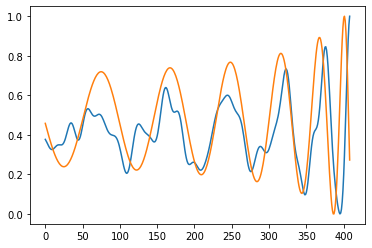

In [ ]:
plt.plot(norm_real)
plt.plot(norm_mod)

In [ ]:
difference = norm_real - norm_mod

(array([ 2.,  2.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,
         3.,  3.,  3.,  1.,  9., 14., 22., 28., 35., 38., 29., 25., 27.,
        18., 39., 27., 18., 13., 15.,  9., 10.,  0.,  2.,  2.,  2.,  2.,
         4.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-0.82609997, -0.79503304, -0.76396611, -0.73289918, -0.70183225,
        -0.67076532, -0.63969839, -0.60863145, -0.57756452, -0.54649759,
        -0.51543066, -0.48436373, -0.4532968 , -0.42222987, -0.39116293,
        -0.360096  , -0.32902907, -0.29796214, -0.26689521, -0.23582828,
        -0.20476135, -0.17369442, -0.14262748, -0.11156055, -0.08049362,
        -0.04942669, -0.01835976,  0.01270717,  0.0437741 ,  0.07484104,
         0.10590797,  0.1369749 ,  0.16804183,  0.19910876,  0.23017569,
         0.26124262,  0.29230955,  0.32337649,  0.35444342,  0.38551035,
         0.41657728,  0.44764421,  0.47871114,  0.50977807,  0.54084501,
         0.57191194,  0.60297887,  0.6340458 ,  0.66511273,

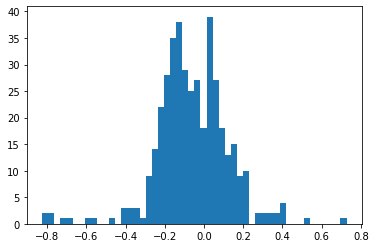

In [ ]:
# difference = difference.detach().numpy()
# plt.plot(x_real[0])
# plt.plot(gw150912hc*10e19)
# plt.plot(difference)
plt.hist(difference, 50)

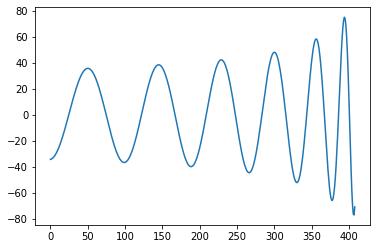

In [ ]:
plt.plot(values[62534])

In [ ]:
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=30.6,
                         mass2=35.6,
                         delta_t=1.0/4096,
                         f_lower=30)
    
times = np.array(hc.sample_times)
wanted_index = np.where((times>=-0.1) & (times<=0))

times = times[wanted_index]
gw150912hc = np.array(hc[wanted_index])

In [ ]:
np.mean(difference), np.std(difference)
noise = np.random.normal(np.mean(difference), np.std(difference),409)

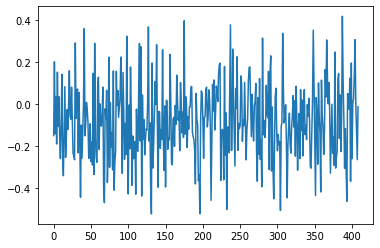

In [ ]:
plt.plot(noise)

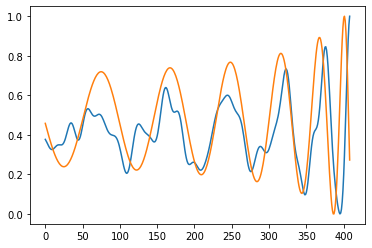

In [ ]:
plt.plot(norm_mod+difference)
plt.plot(norm_mod)

In [ ]:
def load_modeled_data():

    features = np.loadtxt('/content/drive/My Drive/Pesquisa/PPGIA/gw_ultimate-main/phase1/data_high_05_step_feature_20_40_300.csv', delimiter=',')
    label = np.loadtxt('/content/drive/My Drive/Pesquisa/PPGIA/gw_ultimate-main/phase1/data_05_step_label.csv', delimiter=',')

    features = min_max_local(features)

    x_train, x_test_validation, y_train, y_test_validation = train_test_split(features, label, test_size=0.3,
                                                                              random_state=seed)
    x_test, x_validation, y_test, y_validation = train_test_split(x_test_validation, y_test_validation, test_size=0.5,
                                                                  random_state=seed)

    x_train_tensor = torch.tensor(x_train, dtype=torch.float)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float)
    x_validation_tensor = torch.tensor(x_validation, dtype=torch.float)
    y_validation_tensor = torch.tensor(y_validation, dtype=torch.float)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float)

    dataset_train = TensorDataset(x_train_tensor, y_train_tensor)
    dataset_validation = TensorDataset(x_validation_tensor, y_validation_tensor)

    train_loader = DataLoader(dataset=dataset_train, batch_size=x_train.shape[0])
    val_loader = DataLoader(dataset=dataset_validation, batch_size=x_validation.shape[0])
    test_tuple = (x_test_tensor, y_test_tensor)

    return train_loader, val_loader, test_tuple

Model training

In [ ]:
def training_nn(model, train_loader, val_loader, epochs=1000, lr=0.001, loss_function=nn.MSELoss(), early_stop=None):

    train_track = []
    validation_track = []

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):

        for x_batch, y_batch in train_loader:

            optimizer.zero_grad()
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            loss.backward()
            optimizer.step()
            model.train()
            # train_track.append(loss.item())

            with torch.no_grad():
                for x_val, y_val in val_loader:
                    y_out = model(x_val)
                    val_loss = loss_function(y_val, y_out)

            #         validation_track.append(val_loss.item())

    return model, optimizer, train_track, validation_track, val_loss.item()


def training_es_cv(path, network_name, model, optimizer, train_loader, val_loader, epochs, es_limit=100, epochs_limit=50000, loss_function=nn.MSELoss()):
    print('Training with Cross Validation')
    training_track, validation_track = [], []

    with torch.no_grad():
            for x_val, y_val in val_loader:

                y_out = model(x_val)
                minimum = loss_function(y_val, y_out)

    es_count = 0
    
    best_model = model

    # Early stop rules: after 10 epochs if we have no evolution stop
    # or after 50.000 epochs

    for i in range(0, epochs_limit):

        for x_batch, y_batch in train_loader:

            optimizer.zero_grad()
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            loss.backward()
            optimizer.step()
            model.train()
            training_track.append(loss.item())

            with torch.no_grad():
                for x_val, y_val in val_loader:
                    y_out = model(x_val)
                    val_loss = loss_function(y_val, y_out)
                    validation_track.append(val_loss.item())
                    
                if val_loss > minimum*1.05:
                    es_count += 1

                elif val_loss < minimum:
                    minimum = val_loss
                    es_count = 0
                    best_model = model
                    best_epoch = epochs
                    insert_line_stats(path, network_name, best_epoch, best_model, training_track, validation_track)
                    training_track, validation_track = [], []
                
                elif es_count > 0:
                    es_count += 1

                epochs += 1
                    
        if es_count >= es_limit:            
            break

    save_state_model(path, network_name + str(epochs), best_model, optimizer, best_epoch, loss)
    insert_line_stats(path, network_name, epochs, model, training_track, validation_track)

    return model


def training(path, network_name, neural_network, training_data, validation_data, epochs, lr, loss_function, early_stop=None):

    model, optimizer, train_track, validation_track, loss = training_nn(neural_network, training_data, validation_data, epochs, lr, loss_function)

    # save_state_model(path, network_name + 'preliminary', model, optimizer, epochs, loss)
    insert_line_stats(path, network_name + 'preliminary', epochs, model, train_track, validation_track)

    # if early_stop == 'cv':
    # training_es_cv(path, network_name, model, optimizer, training_data, validation_data, epochs, es_limit=100, epochs_limit=50000, loss_function=nn.MSELoss())
    
    return model, train_track, validation_track


In [ ]:
class NN2HiddenLayer(nn.Module):

    def __init__(self, act_function, hidden_layer_units, input_size=300):
        super(NN2HiddenLayer, self).__init__()

        self.input_size = input_size
        self.output_size = 2

        self.act_function = act_function
        self.hidden_units = hidden_layer_units

        self.input = nn.Linear(self.input_size, hidden_layer_units)
        self.hl1 = act_function
        self.linear_hl2 = nn.Linear(hidden_layer_units, hidden_layer_units)
        self.hl2 = act_function
        self.output = nn.Linear(hidden_layer_units, self.output_size)

    def forward(self, x):

        x = self.input(x)
        x = self.hl1(x)
        x = self.linear_hl2(x)
        x = self.hl2(x)
        return self.output(x)
        

class NN3HiddenLayer(nn.Module):

    def __init__(self, act_function, hidden_layer_units, input_size=300):
        super(NN3HiddenLayer, self).__init__()

        self.input_size = input_size
        self.output_size = 2

        if type(act_function) == list:
            self.input = nn.Linear(self.input_size, hidden_layer_units[0])
            self.hl1 = act_function[0]
            self.linear_hl2 = nn.Linear(hidden_layer_units[0], hidden_layer_units[1])
            self.hl2 = act_function[1]
            self.linear_hl3 = nn.Linear(hidden_layer_units[1], hidden_layer_units[2])
            self.hl3 = act_function[2]
            self.output = nn.Linear(hidden_layer_units[2], self.output_size)

        else:
            self.act_function = act_function
            self.hidden_units = hidden_layer_units

            self.input = nn.Linear(self.input_size, hidden_layer_units)
            self.hl1 = act_function
            self.linear_hl2 = nn.Linear(hidden_layer_units, hidden_layer_units)
            self.hl2 = act_function
            self.linear_hl3 = nn.Linear(hidden_layer_units, hidden_layer_units)
            self.hl3 = act_function
            self.output = nn.Linear(hidden_layer_units, self.output_size)

    def forward(self, x):

        x = self.input(x)
        x = self.hl1(x)
        x = self.linear_hl2(x)
        x = self.hl2(x)
        x = self.linear_hl3(x)
        x = self.hl3(x)
        return self.output(x)


class NN5HiddenLayer(nn.Module):

    def __init__(self, act_function, hidden_layer_units, input_size=300):
        super(NN5HiddenLayer, self).__init__()

        self.input_size = input_size
        self.output_size = 2

        self.act_function = act_function
        self.hidden_units = hidden_layer_units

        self.input = nn.Linear(self.input_size, hidden_layer_units)
        self.hl1 = act_function
        self.linear_hl2 = nn.Linear(hidden_layer_units, hidden_layer_units)
        self.hl2 = act_function
        self.linear_hl3 = nn.Linear(hidden_layer_units, hidden_layer_units)
        self.hl3 = act_function
        self.linear_hl4 = nn.Linear(hidden_layer_units, hidden_layer_units)
        self.hl4 = act_function
        self.linear_hl5 = nn.Linear(hidden_layer_units, hidden_layer_units)
        self.hl5 = act_function
        self.output = nn.Linear(hidden_layer_units, self.output_size)

    def forward(self, x):

        x = self.input(x)
        x = self.hl1(x)
        x = self.linear_hl2(x)
        x = self.hl2(x)
        x = self.linear_hl3(x)
        x = self.hl3(x)
        x = self.linear_hl4(x)
        x = self.hl4(x)
        x = self.linear_hl5(x)
        x = self.hl5(x)
        return self.output(x)


class NN10HiddenLayer(nn.Module):

    def __init__(self, act_function, hidden_layer_units, input_size=300):
        super(NN10HiddenLayer, self).__init__()

        self.input_size = input_size
        self.output_size = 2

        self.act_function = act_function
        self.hidden_units = hidden_layer_units

        self.input = nn.Linear(self.input_size, hidden_layer_units)
        self.hl1 = act_function
        self.linear_hl2 = nn.Linear(hidden_layer_units, hidden_layer_units)
        self.hl2 = act_function
        self.linear_hl3 = nn.Linear(hidden_layer_units, hidden_layer_units)
        self.hl3 = act_function
        self.linear_hl4 = nn.Linear(hidden_layer_units, hidden_layer_units)
        self.hl4 = act_function
        self.linear_hl5 = nn.Linear(hidden_layer_units, hidden_layer_units)
        self.hl5 = act_function
        self.linear_hl6 = nn.Linear(hidden_layer_units, hidden_layer_units)
        self.hl6 = act_function
        self.linear_hl7 = nn.Linear(hidden_layer_units, hidden_layer_units)
        self.hl7 = act_function
        self.linear_hl8 = nn.Linear(hidden_layer_units, hidden_layer_units)
        self.hl8 = act_function
        self.linear_hl9 = nn.Linear(hidden_layer_units, hidden_layer_units)
        self.hl9 = act_function
        self.linear_hl10 = nn.Linear(hidden_layer_units, hidden_layer_units)
        self.hl10 = act_function
        self.output = nn.Linear(hidden_layer_units, self.output_size)

    def forward(self, x):

        x = self.input(x)
        x = self.hl1(x)
        x = self.linear_hl2(x)
        x = self.hl2(x)
        x = self.linear_hl3(x)
        x = self.hl3(x)
        x = self.linear_hl4(x)
        x = self.hl4(x)
        x = self.linear_hl5(x)
        x = self.hl5(x)
        x = self.linear_hl6(x)
        x = self.hl6(x)
        x = self.linear_hl7(x)
        x = self.hl7(x)
        x = self.linear_hl8(x)
        x = self.hl8(x)
        x = self.linear_hl9(x)
        x = self.hl9(x)
        x = self.linear_hl10(x)
        x = self.hl10(x)
        return self.output(x)


def mse_my_loss(output, target):
    out_m1 = output[:, 0]
    out_m2 = output[:, 1]
    targ_m1 = target[:, 0]
    targ_m2 = target[:, 1]
    loss_result = nn.MSELoss()(output, target) + nn.MSELoss()(out_m1, targ_m1) + nn.MSELoss()(out_m2, targ_m2)
    return loss_result


class Sin(nn.Module):
    """Class to implement the sin function"""

    def __init__(self):
        """Initializer method.
        """
        super(Sin,self).__init__()

    def forward(self, input_):
        return torch.sin(input_)

In [ ]:
def run_exp(spec_dict, training_data, validation_data, test_data, rpt, early_stop=None):
    
    count = 0
    
    print('Start Training...')
    start_time = datetime.datetime.now()

    df_path = create_stats_report(spec_dict['exp_path'])

    for network, hl in zip(spec_dict['models'], spec_dict['hidden_layers']):
        for af in spec_dict['act_functions']:
            for hlu in spec_dict['hidden_layer_units']:
                for lr in spec_dict['learning_rates']:

                    partial_start_time = datetime.datetime.now()

                    net_name = network_name(hl, hlu, af, lr)
                    
                    neural_network = network(af, hlu, input_size=409)
                    
                    neural_network.to(device)
                    model, training_track, validation_track = training(df_path, net_name, neural_network, training_data, validation_data, spec_dict['qtd_epochs'], lr, mse_my_loss, early_stop)

                    if rpt:
                        print('Training ' + net_name + ' nº', count, 'done in', datetime.datetime.now() - partial_start_time)

                    count += 1

    print('Finished in ' + str(datetime.datetime.now() - start_time))


In [ ]:
train_data_global, val_data_global, test_data_global = load_data()

In [ ]:
def experiment(name, train_data, val_data, test_data):

    exp_path = experiment_path()

    spec_dict = {
        'models': [NN2HiddenLayer],
        'hidden_layers': [2],
        'act_functions': [nn.ReLU()],
        'hidden_layer_units': [200],
        'learning_rates': [1e-3, 1e-2],
        'qtd_epochs': 1,
        'exp_path': exp_path
    }

    run_exp(spec_dict, train_data, val_data, test_data, rpt=True)

    print('Experiment with histogram' + name + 'completed with success!')


In [ ]:
def experiment_sin(name, train_data, val_data, test_data):

    exp_path = experiment_path()

    spec_dict = {
        'models': [NN3HiddenLayer, NN5HiddenLayer, NN10HiddenLayer],
        'hidden_layers': [3, 5, 10],
        'act_functions': [Sin(), nn.ReLU()],
        'hidden_layer_units': [20, 50, 100, 150, 200],
        'learning_rates': [1e-2, 1e-3],
        'qtd_epochs': 1000,
        'exp_path': exp_path
    }

    run_exp(spec_dict, train_data, val_data, test_data, rpt=True, early_stop=None)

    print('Experiment with ' + name + 'completed with success!')

# experiment_sin('funções seno', train_data_global, val_data_global, test_data_global)

In [ ]:
for i in range(20):
    experiment_sin('Cross Validation', val_data_global, val_data_global, val_data_global)

Start Training...
Training nn3hlu20afSinlr1e-02 nº 0 done in 0:03:28.362315
Training nn3hlu20afSinlr1e-03 nº 1 done in 0:03:25.306771
Training nn3hlu50afSinlr1e-02 nº 2 done in 0:03:24.875452
Training nn3hlu50afSinlr1e-03 nº 3 done in 0:03:23.766622
Training nn3hlu100afSinlr1e-02 nº 4 done in 0:03:22.407564
Training nn3hlu100afSinlr1e-03 nº 5 done in 0:03:31.895164
Training nn3hlu150afSinlr1e-02 nº 6 done in 0:03:31.706083
Training nn3hlu150afSinlr1e-03 nº 7 done in 0:03:31.612103
Training nn3hlu200afSinlr1e-02 nº 8 done in 0:03:31.511032
Training nn3hlu200afSinlr1e-03 nº 9 done in 0:03:33.518264


In [ ]:
def experimentnn2hlu200afReLUlr(name, train_data, val_data, test_data):

    exp_path = experiment_path()

    spec_dict = {
        'models': [NN2HiddenLayer],
        'hidden_layers': [2],
        'act_functions': [nn.ReLU()],
        'hidden_layer_units': [200],
        'learning_rates': [1e-3, 1e-2],
        'qtd_epochs': 1000,
        'exp_path': exp_path
    }

    run_exp(spec_dict, train_data, val_data, test_data, rpt=True)

    print('Experiment with histogram' + name + 'completed with success!')

# experimentnn2hlu200afReLUlr('Teste uma da manhã com nn2hlu200afReLUlr1e-02 e 03 ', train_data_global, val_data_global, test_data_global)

In [ ]:
def experimentnn2hlu150afReLUlr(name, train_data, val_data, test_data):

    exp_path = experiment_path()

    spec_dict = {
        'models': [NN2HiddenLayer],
        'hidden_layers': [2],
        'act_functions': [nn.ReLU()],
        'hidden_layer_units': [150],
        'learning_rates': [1e-3, 1e-2],
        'qtd_epochs': 1000,
        'exp_path': exp_path
    }

    run_exp(spec_dict, train_data, val_data, test_data, rpt=True)

    print('Experiment with histogram' + name + 'completed with success!')

# experimentnn2hlu200afReLUlr('Teste uma da manhã com nn2hlu150afReLUlr1e-02 e 03 ', train_data_global, val_data_global, test_data_global)

In [ ]:
def experimentnn3hlu150afReLUlr(name, train_data, val_data, test_data):

    exp_path = experiment_path()

    spec_dict = {
        'models': [NN3HiddenLayer],
        'hidden_layers': [3],
        'act_functions': [nn.ReLU()],
        'hidden_layer_units': [150],
        'learning_rates': [1e-3, 1e-2],
        'qtd_epochs': 1000,
        'exp_path': exp_path
    }

    run_exp(spec_dict, train_data, val_data, test_data, rpt=True)

    print('Experiment with histogram' + name + 'completed with success!')

# experimentnn3hlu150afReLUlr('Teste uma da manhã com nn3hlu150afReLUlr1e-02 e 03 ', train_data_global, val_data_global, test_data_global)

In [ ]:
# 28	nn5hlu200afSinlr1e-02preliminary	1.177031
# 18	nn3hlu200afSinlr1e-02preliminary	2.162942
# 8	    nn2hlu200afSinlr1e-02preliminary	2.923978

def experimentnn3hlu200afSinlr(name, train_data, val_data, test_data):

    exp_path = experiment_path()

    spec_dict = {
        'models': [NN3HiddenLayer],
        'hidden_layers': [3],
        'act_functions': [Sin()],
        'hidden_layer_units': [200],
        'learning_rates': [1e-3, 1e-2],
        'qtd_epochs': 1000,
        'exp_path': exp_path
    }

    run_exp(spec_dict, train_data, val_data, test_data, rpt=True)

    print('Experiment with histogram' + name + 'completed with success!')

experimentnn3hlu200afSinlr('Teste uma da manhã com nn3hlu150afSin-02 e 03 ', train_data_global, val_data_global, test_data_global)

Start Training...
Training with Cross Validation
Training nn3hlu200afSinlr1e-03 nº 0 done in 0:47:22.817211
Training with Cross Validation
Training nn3hlu200afSinlr1e-02 nº 1 done in 0:15:29.981093
Finished in 1:02:52.809005
Experiment with histogramTeste uma da manhã com nn3hlu150afSin-02 e 03 completed with success!


In [ ]:
def experimentnn5hlu200afSinlr(name, train_data, val_data, test_data):

    exp_path = experiment_path()

    spec_dict = {
        'models': [NN5HiddenLayer],
        'hidden_layers': [5],
        'act_functions': [Sin()],
        'hidden_layer_units': [200],
        'learning_rates': [1e-3, 1e-2],
        'qtd_epochs': 1000,
        'exp_path': exp_path
    }

    run_exp(spec_dict, train_data, val_data, test_data, rpt=True)

    print('Experiment with histogram' + name + 'completed with success!')

experimentnn5hlu200afSinlr('Teste uma da manhã com nn5hlu150afSin-02 e 03 ', train_data_global, val_data_global, test_data_global)

Start Training...
Training with Cross Validation
Training nn5hlu200afSinlr1e-03 nº 0 done in 0:29:54.866859
Training with Cross Validation
Training nn5hlu200afSinlr1e-02 nº 1 done in 0:20:15.434229
Finished in 0:50:10.311030
Experiment with histogramTeste uma da manhã com nn5hlu150afSin-02 e 03 completed with success!


In [ ]:
def experimentnn2hlu200afSinlr(name, train_data, val_data, test_data):

    exp_path = experiment_path()

    spec_dict = {
        'models': [NN2HiddenLayer],
        'hidden_layers': [2],
        'act_functions': [Sin()],
        'hidden_layer_units': [200],
        'learning_rates': [1e-3, 1e-2],
        'qtd_epochs': 1000,
        'exp_path': exp_path
    }

    run_exp(spec_dict, train_data, val_data, test_data, rpt=True)

    print('Experiment with histogram' + name + 'completed with success!')

experimentnn2hlu200afSinlr('Teste uma da manhã com nn2hlu150afSin-02 e 03 ', train_data_global, val_data_global, test_data_global)

Start Training...
Training with Cross Validation
Training nn2hlu200afSinlr1e-03 nº 0 done in 1:03:18.572649
Training with Cross Validation
Training nn2hlu200afSinlr1e-02 nº 1 done in 0:15:21.727537
Finished in 1:18:40.311846
Experiment with histogramTeste uma da manhã com nn2hlu150afSin-02 e 03 completed with success!
